### Company XYZ is a worldwide e-commerce site with localized versions of the site. A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country. She therefore went and talked to the international team in charge of Spain and LatAm to see if they had any ideas about why that was happening. Spain and LatAm country manager suggested that one reason could be the translation. All Spanish-speaking countries had the same translation of the site which was written by a Spaniard. They agreed to try a test where each country would have its one translation written by a local. That is, Argentinian users would see a translation written by an Argentinian, and Mexican users by a Mexican and so on. Obviously, nothing would change for users from Spain. After they run the test, however, they are really surprised cause the test is negative. I.e., it appears that the non-localized translation was doing better!

### You are asked to:
#### (1) Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better

#### (2) Explain why that might be happening. Are the localized translations really worse?

#### (3) If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

### Load the package would be used

In [1]:
import pandas as pd
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 350)

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({"figure.autolayout": True})
import seaborn as sns
sns.set(style = "white")
sns.set(style = "whitegrid", color_codes = True)

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.tree import H2OTree

### Read in the data set

In [2]:
user = pd.read_csv("../Datasets/Translation_Test/user_table.csv")
test = pd.read_csv("../Datasets/Translation_Test/test_table.csv")

print(user.shape)
print(test.shape)

(452867, 4)
(453321, 9)


### Look into the data set

In [3]:
print(user["user_id"].nunique() == len(user["user_id"]))
print(test["user_id"].nunique() == len(test["user_id"]))
print(len(test["user_id"]) - len(user["user_id"]))

True
True
454


It seems that some user_ids are missing. We need to use inner join (or left join user on test). 

In [4]:
dat0 = test.merge(user, on = ["user_id"])
print(dat0.info())
dat0["date"] = pd.to_datetime(dat0["date"])
print(dat0.info())
print(dat0.describe())
dat0.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 452867 entries, 0 to 452866
Data columns (total 12 columns):
user_id             452867 non-null int64
date                452867 non-null object
source              452867 non-null object
device              452867 non-null object
browser_language    452867 non-null object
ads_channel         181693 non-null object
browser             452867 non-null object
conversion          452867 non-null int64
test                452867 non-null int64
sex                 452867 non-null object
age                 452867 non-null int64
country             452867 non-null object
dtypes: int64(4), object(8)
memory usage: 44.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 452867 entries, 0 to 452866
Data columns (total 12 columns):
user_id             452867 non-null int64
date                452867 non-null datetime64[ns]
source              452867 non-null object
device              452867 non-null object
browser_language    452867 non-

,user_id,date,source,device,browser_language,...,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,...,1,0,M,32,Spain
1,497851,2015-12-04,Ads,Web,ES,...,0,1,M,21,Mexico
2,848402,2015-12-04,Ads,Web,ES,...,0,0,M,34,Spain
3,290051,2015-12-03,Ads,Mobile,Other,...,0,1,F,22,Mexico
4,548435,2015-11-30,Ads,Web,ES,...,0,1,M,19,Mexico


### Check the conversion rate of each country to see if Spain converts much better

In [5]:
country_conversion = dat0.query("test == 0").groupby("country")["conversion"].mean()
print(country_conversion.sort_values(ascending = False))

country
Spain          0.079719
El Salvador    0.053554
Nicaragua      0.052647
Costa Rica     0.052256
Colombia       0.052089
Honduras       0.050906
Guatemala      0.050643
Venezuela      0.050344
Peru           0.049914
Mexico         0.049495
Bolivia        0.049369
Ecuador        0.049154
Paraguay       0.048493
Chile          0.048107
Panama         0.046796
Argentina      0.015071
Uruguay        0.012048
Name: conversion, dtype: float64


It is true that users in Spain converted the highest.

### Compare the conversion rates of the test group and that of the control group.

In [6]:
dat = dat0.query('country != "Spain"')

test_overall = stats.ttest_ind(dat[dat["test"] == 1]["conversion"],
                               dat[dat["test"] == 0]["conversion"],
                               equal_var = False)

print(dat.groupby("test")["conversion"].mean())
print(test_overall.statistic)
print(test_overall.pvalue)

test
0    0.048292
1    0.043411
Name: conversion, dtype: float64
-7.353895203080277
1.9289178577799033e-13


Controls users are converting at $4.8\%$ while test users just at $4.3\%$. Possible reasons include:

- We do not have enough sample size.

- Randomization does not work very well.

### Visualization

#### By country

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


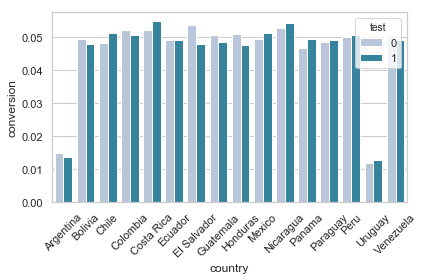

In [7]:
grp_country = dat[["test", "country", "conversion"]].groupby(["test", "country"]).mean().reset_index()
sns.barplot(x = "country", y = "conversion", hue = "test", data = grp_country, palette = "PuBuGn")
plt.xticks(rotation = 45)

#### By marketing channels

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


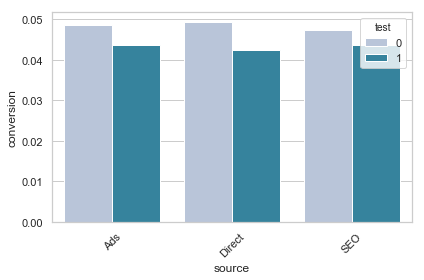

In [8]:
grp_source = dat[["test", "source", "conversion"]].groupby(["test", "source"]).mean().reset_index()
sns.barplot(x = "source", y = "conversion", hue = "test", data = grp_source, palette = "PuBuGn")
plt.xticks(rotation = 45)

#### By device type

(array([0, 1]), <a list of 2 Text xticklabel objects>)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


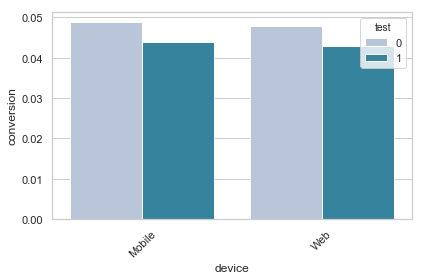

In [9]:
grp_device = dat[["test", "device", "conversion"]].groupby(["test", "device"]).mean().reset_index()
sns.barplot(x = "device", y = "conversion", hue = "test", data = grp_device, palette = "PuBuGn")
plt.xticks(rotation = 45)

#### By browser language

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


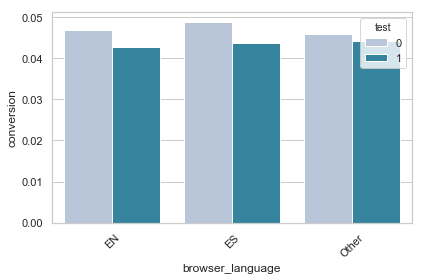

In [10]:
grp_language = dat[["test", "browser_language", "conversion"]].groupby(["test", "browser_language"]).mean().reset_index()
sns.barplot(x = "browser_language", y = "conversion", hue = "test", data = grp_language, palette = "PuBuGn")
plt.xticks(rotation = 45)

#### By sex

(array([0, 1]), <a list of 2 Text xticklabel objects>)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


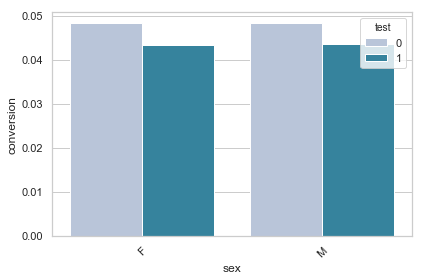

In [11]:
grp_sex = dat[["test", "sex", "conversion"]].groupby(["test", "sex"]).mean().reset_index()
sns.barplot(x = "sex", y = "conversion", hue = "test", data = grp_sex, palette = "PuBuGn")
plt.xticks(rotation = 45)

#### By date

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(array([735932. , 735932.5, 735933. , 735933.5, 735934. , 735934.5,
        735935. , 735935.5, 735936. ]), <a list of 9 Text xticklabel objects>)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


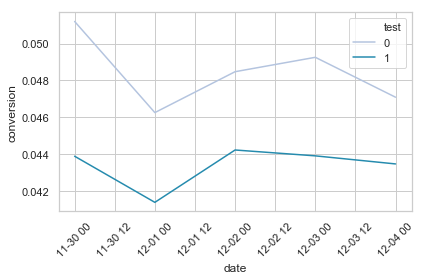

In [12]:
grp_date = dat[["test", "date", "conversion"]].groupby(["test", "date"]).mean().reset_index()
sns.lineplot(x = "date", y = "conversion", hue = "test", data = grp_date, palette = "PuBuGn")
plt.xticks(rotation = 45)

#### By age

(array([10., 20., 30., 40., 50., 60., 70., 80.]),
 <a list of 8 Text xticklabel objects>)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


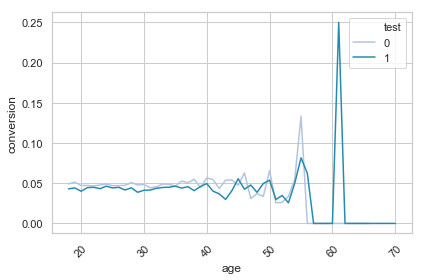

In [13]:
grp_age = dat[["test", "age", "conversion"]].groupby(["test", "age"]).mean().reset_index()
sns.lineplot(x = "age", y = "conversion", hue = "test", data = grp_age, palette = "PuBuGn")
plt.xticks(rotation = 45)

Based on the above plots, the randomization may not work well for the country variable. Let's do stratified t-test to examine further.

### Stratified t-test

#### By country

In [14]:
test_country = dat.groupby("country")["conversion"].agg({
    "p_value": lambda x: stats.ttest_ind(x[dat["test"] == 1], x[dat["test"] == 0], equal_var=False).pvalue,
    "conversion_test": lambda x: x[dat["test"] == 1].mean(),
    "conversion_control": lambda x: x[dat["test"] == 0].mean()
}).reindex(["p_value", "conversion_test", "conversion_control"], axis = 1)
print(test_country.sort_values(by = ["p_value"]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


              p_value  conversion_test  conversion_control
country                                                   
Mexico       0.165544         0.051186            0.049495
El Salvador  0.248127         0.047947            0.053554
Chile        0.302848         0.051295            0.048107
Argentina    0.335147         0.013725            0.015071
Colombia     0.423719         0.050571            0.052089
Honduras     0.471463         0.047540            0.050906
Guatemala    0.572107         0.048647            0.050643
Venezuela    0.573702         0.048978            0.050344
Costa Rica   0.687876         0.054738            0.052256
Panama       0.705327         0.049370            0.046796
Bolivia      0.718885         0.047901            0.049369
Peru         0.771953         0.050604            0.049914
Nicaragua    0.780400         0.054177            0.052647
Uruguay      0.879764         0.012907            0.012048
Paraguay     0.883697         0.049229            0.0484

#### By marketing channels

In [15]:
test_source = dat.groupby("source")["conversion"].agg({
    "p_value": lambda x: stats.ttest_ind(x[dat["test"] == 1], x[dat["test"] == 0], equal_var=False).pvalue,
    "conversion_test": lambda x: x[dat["test"] == 1].mean(),
    "conversion_control": lambda x: x[dat["test"] == 0].mean()
}).reindex(["p_value", "conversion_test", "conversion_control"], axis = 1)
print(test_source.sort_values(by = ["p_value"]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


             p_value  conversion_test  conversion_control
source                                                   
Ads     9.208417e-07         0.043529            0.048687
Direct  6.109499e-06         0.042512            0.049224
SEO     4.434961e-04         0.043742            0.047422


#### By device type

In [16]:
test_device = dat.groupby("device")["conversion"].agg({
    "p_value": lambda x: stats.ttest_ind(x[dat["test"] == 1], x[dat["test"] == 0], equal_var=False).pvalue,
    "conversion_test": lambda x: x[dat["test"] == 1].mean(),
    "conversion_control": lambda x: x[dat["test"] == 0].mean()
}).reindex(["p_value", "conversion_test", "conversion_control"], axis = 1)
print(test_device.sort_values(by = ["p_value"]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


             p_value  conversion_test  conversion_control
device                                                   
Web     2.367801e-08         0.042931            0.047882
Mobile  1.633659e-06         0.044008            0.048804


#### By browser language

In [17]:
test_language = dat.groupby("browser_language")["conversion"].agg({
    "p_value": lambda x: stats.ttest_ind(x[dat["test"] == 1], x[dat["test"] == 0], equal_var=False).pvalue,
    "conversion_test": lambda x: x[dat["test"] == 1].mean(),
    "conversion_control": lambda x: x[dat["test"] == 0].mean()
}).reindex(["p_value", "conversion_test", "conversion_control"], axis = 1)
print(test_language.sort_values(by = ["p_value"]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


                       p_value  conversion_test  conversion_control
browser_language                                                   
ES                2.565235e-12         0.043519            0.048622
EN                1.660422e-02         0.042616            0.046825
Other             6.899849e-01         0.044152            0.045721


#### By date

In [18]:
test_date = dat.groupby("date")["conversion"].agg({
    "p_value": lambda x: stats.ttest_ind(x[dat["test"] == 1], x[dat["test"] == 0], equal_var=False).pvalue,
    "conversion_test": lambda x: x[dat["test"] == 1].mean(),
    "conversion_control": lambda x: x[dat["test"] == 0].mean()
}).reindex(["p_value", "conversion_test", "conversion_control"], axis = 1)
print(test_date.sort_values(by = ["p_value"]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


             p_value  conversion_test  conversion_control
date                                                     
2015-11-30  0.000018         0.043878            0.051204
2015-12-03  0.000174         0.043898            0.049255
2015-12-04  0.002149         0.043459            0.047085
2015-12-01  0.002956         0.041371            0.046249
2015-12-02  0.011801         0.044216            0.048472


With adjustment of country, the test appears non-significant. 

### Machine Learning Model

In [19]:
#### Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,1 min 21 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.1
H2O cluster version age:,11 hours and 1 minute
H2O cluster name:,H2O_from_python_veronica_85cm3z
H2O cluster total nodes:,1
H2O cluster free memory:,3.928 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


#### Convert data set to h2o format

In [20]:
dat_h2o = H2OFrame(dat)
dat_h2o["conversion"] = dat_h2o["conversion"].asfactor()
dat_h2o["country"] = dat_h2o["country"].asfactor()
dat_h2o["source"] = dat_h2o["source"].asfactor()
dat_h2o["device"] = dat_h2o["device"].asfactor()
dat_h2o["browser_language"] = dat_h2o["browser_language"].asfactor()
dat_h2o["ads_channel"] = dat_h2o["ads_channel"].asfactor()
dat_h2o["sex"] = dat_h2o["sex"].asfactor()
dat_h2o["browser"] = dat_h2o["browser"].asfactor()
dat_h2o.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
type,int,time,enum,enum,enum,enum,enum,enum,int,enum,int,enum
mins,1.0,1448841600000.0,,,,,,,0.0,,18.0,
mean,499897.254965906,1449046585472.9,,,,,,,0.5379757408030716,,27.12814989341405,
maxs,1000000.0,1449187200000.0,,,,,,,1.0,,70.0,
sigma,288720.8669441521,125494322.60752755,,,,,,,0.49855637878342063,,6.774760413689508,
zeros,0,0,,,,,,,185311,,0,
missing,0,0,0,0,0,0,0,0,0,0,0,0
0,497851.0,2015-12-04 00:00:00,Ads,Web,ES,Google,IE,0,1.0,M,21.0,Mexico
1,290051.0,2015-12-03 00:00:00,Ads,Mobile,Other,Facebook,Android_App,0,1.0,F,22.0,Mexico
2,548435.0,2015-11-30 00:00:00,Ads,Web,ES,Google,FireFox,0,1.0,M,19.0,Mexico


#### Split data set to training set and testing set

In [21]:
index = dat_h2o["conversion"].stratified_split(test_frac = 0.34, seed = 2019)
train_dat = dat_h2o[index == "train"]
test_dat = dat_h2o[index == "test"]
X = ["country", "source", "sex", "device", "browser_language", "ads_channel", "browser"]
Y = "conversion"

#### Build a boosting tree

In [22]:
GBM = H2OGradientBoostingEstimator(balance_classes = True, ntrees = 1, min_rows = 1, sample_rate = 1,  
                                   col_sample_rate = 1, max_depth = 5, seed = 2019)
GBM.train(x = X, y = Y, training_frame = train_dat)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [23]:
tree = H2OTree(model = GBM, tree_number = 0, tree_class = None)
print(tree.root_node)

Node ID 0 
Left child node ID = 1
Right child node ID = 2

Splits on column country
  - Categorical levels going to the left node: ['Argentina', 'Uruguay']
  - Categorical levels going to the right node: ['Bolivia', 'Chile', 'Colombia', 'Costa Rica', 'Ecuador', 'El Salvador', 'Guatemala', 'Honduras', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay', 'Peru', 'Venezuela']

NA values go to the RIGHT


It is clearly that the tree splits at the country, indicating that the ramdomization may not work well for that variable.